# 7641 ML Assignment 3: Unsupervised Learning and Dimensionality Reduction

### Import Libraries 

In [40]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.random_projection import GaussianRandomProjection
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

### Import Datasets

In [4]:
stroke_df = pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
mobile = pd.read_csv("Mobile-Prediction-train.csv")
mobile.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


### Data Preprocessing

#### Stroke Prediction

In [6]:
stroke_df = stroke_df.dropna()
stroke_df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [7]:
# One hot encode target values
encoder = preprocessing.LabelEncoder()
stroke_df['gender']=encoder.fit_transform(stroke_df['gender'].values)
stroke_df['ever_married']=encoder.fit_transform(stroke_df['ever_married'].values)
stroke_df['work_type']=encoder.fit_transform(stroke_df['work_type'].values)
stroke_df['Residence_type']=encoder.fit_transform(stroke_df['Residence_type'].values)
stroke_df['smoking_status']=encoder.fit_transform(stroke_df['smoking_status'].values)
stroke_df.head()
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   int32  
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   int32  
 6   work_type          4909 non-null   int32  
 7   Residence_type     4909 non-null   int32  
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   int32  
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int32(5), int64(4)
memory usage: 402.7 KB


In [8]:
stroke_X = stroke_df.drop('stroke', axis = 1).values
stroke_y = stroke_df['stroke'].values

In [9]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(stroke_X, stroke_y, test_size = 0.3, random_state = 1)

#### Mobile Prediction

In [10]:
mobile_X = mobile.drop('price_range', axis = 1).values
mobile_y = mobile['price_range'].values

In [11]:
# Split data into training and test sets
Xm_train, Xm_test, ym_train, ym_test = train_test_split(mobile_X, mobile_y, test_size = 0.3, random_state = 1)

# Normalize feature data
scaler = MinMaxScaler()

Xm_train_scaled = scaler.fit_transform(Xm_train)
Xm_test_scaled = scaler.transform(Xm_test)

# One hot encode target values
one_hot = OneHotEncoder()

ym_train_hot = one_hot.fit_transform(ym_train.reshape(-1, 1)).todense()
ym_test_hot = one_hot.transform(ym_test.reshape(-1, 1)).todense()

### Helper Functions

In [12]:
# Score plot
def score_plot(clusters, scores, xlabel, ylabel, title):

    plt.plot(clusters, scores, 'o-', color='b', label="k-means")
#     plt.plot(clusters, homo_scores, 'o-', color='g', label="em")
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()



In [13]:
# K-means Clustering 
def kmeans(X, y, num, title):
    clusters = list(np.arange(2,num,2))
    silhouette = []
    train_times = []
    Sum_of_squared_distances = []
    silhouette_avg = []
    
    for k in clusters:
        start_time = time.time()
        kmeans = KMeans(n_clusters=k, n_init=10,random_state=52).fit(X)
        end_time = time.time()
        train_times.append(end_time - start_time)
              
        # Silhouette Analysis
        silhouette_avg.append(silhouette_score(X, kmeans.labels_))
        
        # Elbow Method
        Sum_of_squared_distances.append(kmeans.inertia_)
        
#     plt.plot(clusters, Sum_of_squared_distances,'o-')
#     plt.xlabel('Values of K') 
#     plt.ylabel('Sum of squared distances/Inertia')     
#     plt.title('Elbow Method For Optimal k')
#     plt.show()
    # Elbow Method
    score_plot(clusters, Sum_of_squared_distances, 'Values of K', 'Sum of squared distances/Inertia', title + ' Elbow Method')
    

    score_plot(clusters, silhouette_avg , 'Values of K', 'Silhouette Score', title + ' Silhouette analysis For Optimal k')
    

In [14]:
# Expectation Maximization
def EM(X, y, title):
    kdist = list(np.arange(2,50,5))
    silhouette = [];
    train_times = [];
    
    for k in kdist:
        start_time = time.time()
        em = GaussianMixture(n_components=k, covariance_type='diag', n_init=1, warm_start=True,random_state=100).fit_predict(X)
        end_time = time.time()
        train_times.append(end_time - start_time)
        
        
        silhouette.append(silhouette_score(X, em, metric='euclidean'))


    # silhouette score plot
    score_plot(kdist, silhouette, 'Number of Clusters', 'Avg Silhouette Score', title)
    
    
  

In [15]:
# PCA
def run_PCA(X,y,title):
    
    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()

In [16]:
# ICA
def run_ICA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),1))
    dims.append(X.shape[1])
    ica = ICA(random_state=5)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

In [17]:
def run_RCA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),1))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()
    
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

In [18]:
# RP
def run_RP(X, comp, hist=True):
    stroke_data_RP = GaussianRandomProjection(random_state=0, n_components= comp)
    new_stroke_data_RP = stroke_data_RP.fit_transform(X)
    stroke_data_RP_df = pd.DataFrame(data = new_stroke_data_RP)
    
    
    if hist:
        plt.hist(stroke_data_RP.components_.flatten())
        plt.title('Histogram of the flattened transformation matrix')
        plt.show()
    
    return stroke_data_RP_df
    

In [87]:
# Comparing Fit Time
def compare_fit_time(train_size, gd_fit, pca_fit, ica_fit, rca_fit, title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time")
    plt.plot(train_size, gd_fit, '-', color="m", label="Full Dataset")
    plt.plot(train_size, pca_fit, '-', color="r", label="PCA")
    plt.plot(train_size, ica_fit, '-', color="g", label="ICA")
    plt.plot(train_size, rca_fit, '-', color="b", label="RCA")
    plt.plot(train_size, rp_fit, '-', color="y", label="RFP")
    plt.legend(loc="best")
    plt.show()

In [88]:
def compare_plot_learning_curve(title, train_size, gd_train_scores_mean, pca_train_scores_mean, ica_train_scores_mean, rca_train_scores_mean):
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy Score")
    plt.plot(train_size, gd_train_scores_mean, '-', color="m", label="Full Dataset")
    plt.plot(train_size, pca_train_scores_mean, '-', color="r", label="PCA")
    plt.plot(train_size, ica_train_scores_mean, '-', color="g", label="ICA")
    plt.plot(train_size, rca_train_scores_mean, '-', color="b", label="RCA")
    plt.plot(train_size, rp_train_scores_mean, '-', color="y", label="RP")
    plt.legend(loc="best")
    plt.show()

### Machine Learning

### Step 1: Clustering Algorithms

#### Stroke Prediction

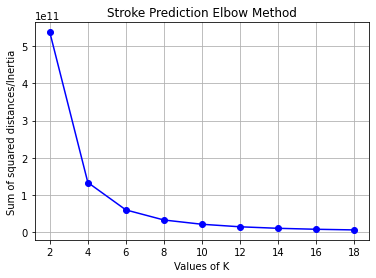

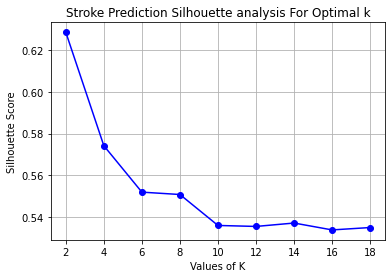

In [21]:
# Searching for optimal number of clusters
kmeans(stroke_X, stroke_y, 20, "Stroke Prediction")

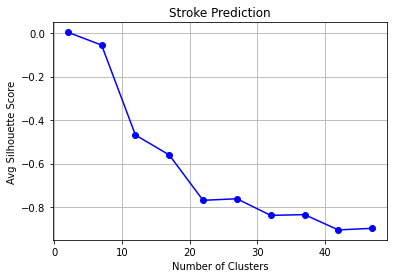

In [22]:
EM(stroke_X, stroke_y, "Stroke Prediction")

#### Mobile Prediction

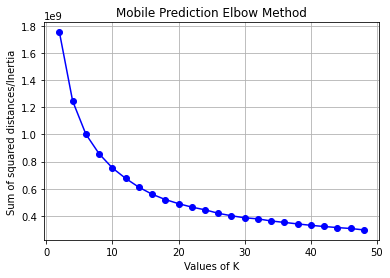

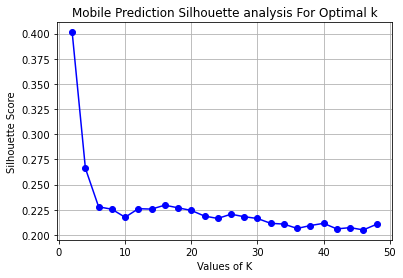

In [23]:
kmeans(mobile_X, mobile_y, 50, "Mobile Prediction")

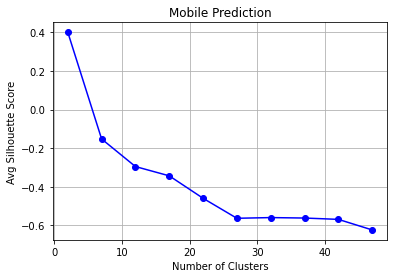

In [24]:
EM(mobile_X, mobile_y, "Mobile Prediction")

### Step 2: Dimensionality Reduction Algorithms

#### Stroke Prediction

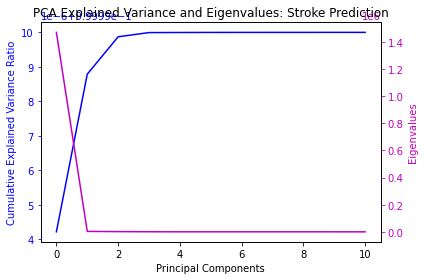

In [25]:
run_PCA(stroke_X, stroke_y, 'Stroke Prediction')

C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fast

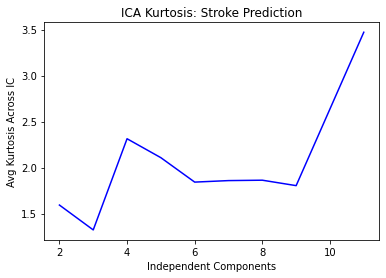

In [26]:
run_ICA(stroke_X,stroke_y, 'Stroke Prediction')

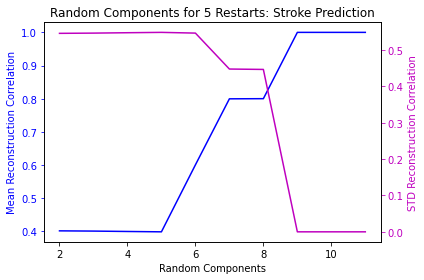

In [27]:
run_RCA(stroke_X,stroke_y, 'Stroke Prediction')

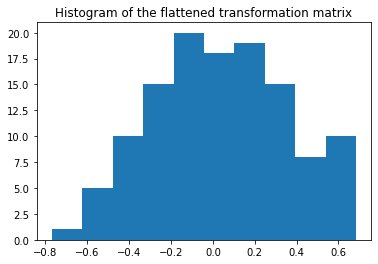

,0,1,2,3,4,5,6,7,8,9,10
0,4829.548130,3882.830818,2419.267520,-5515.920329,-1464.734579,1056.424362,-4444.012414,-1434.140515,-2907.019029,1040.869541,5129.907754
1,16573.290412,13593.680902,8172.473467,-18638.264412,-4840.194583,3971.171563,-15307.458723,-5357.233075,-10035.247562,3735.944230,17527.969805
2,32023.462784,26320.836336,15731.638460,-36030.203303,-9305.561152,7688.476509,-29581.024288,-10393.112224,-19415.455610,7257.796634,33917.547011
3,907.775679,670.446811,499.252570,-1076.407848,-321.711487,131.928321,-823.270394,-182.900630,-532.602583,146.290707,957.844987
4,30163.304326,24781.764550,14838.314686,-33935.533533,-8778.320171,7229.878207,-27859.460037,-9772.788973,-18287.813278,6812.170235,31932.419938
...,...,...,...,...,...,...,...,...,...,...,...
4904,7546.160669,6177.012766,3713.518956,-8522.212929,-2207.469991,1779.397772,-6963.318249,-2410.929792,-4568.737627,1703.292421,8006.643246
4905,23892.696450,19616.604650,11762.659029,-26869.513308,-6960.342797,5738.555335,-22071.182206,-7745.425364,-14473.987018,5403.035569,25282.096200
4906,10502.490244,8605.157277,5172.663201,-11828.057392,-3068.538960,2508.027555,-9699.594841,-3384.699591,-6354.275169,2377.626252,11121.939877
4907,19982.456643,16402.387279,9831.333898,-22504.280072,-5823.965988,4767.638958,-18452.212355,-6448.459765,-12111.880576,4508.970636,21166.522811


In [28]:
run_RP(stroke_X, 11)

#### Mobile Prediction

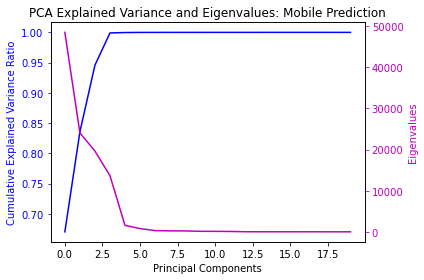

In [29]:
run_PCA(mobile_X, mobile_y, 'Mobile Prediction')

C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fast

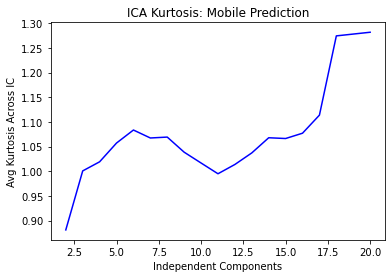

In [30]:
run_ICA(mobile_X, mobile_y, 'Mobile Prediction')

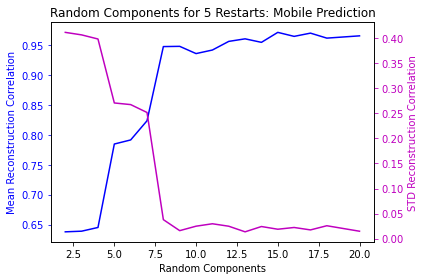

In [31]:
run_RCA(mobile_X, mobile_y, 'Mobile Prediction')

C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\random_projection.py:390: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (20 < 21).The dimensionality of the problem will not be reduced.
  warnings.warn(


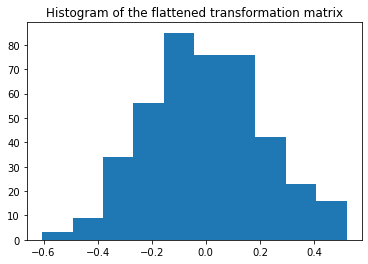

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,529.409761,-1646.550723,-1000.593102,-665.397181,329.446515,1353.916564,6.904853,-900.581009,-267.468199,-747.921834,...,-56.185472,-306.305604,297.300464,-203.105534,-802.284461,-707.814776,44.671892,116.546047,-1203.262714,-288.342160
1,1093.240701,-1968.717781,-1120.183467,-384.845648,617.428231,1378.378684,-70.383909,-840.398412,-29.356099,-746.752822,...,-326.807019,-387.678309,254.939241,280.907820,-983.329157,-772.789745,156.160185,172.110703,-1466.015016,-234.156127
2,982.925468,-1613.749297,-947.826680,-365.795649,806.343997,1305.949505,-22.695552,-506.793240,3.782494,-678.964767,...,-240.479334,-382.143077,37.054508,128.914538,-691.723041,-830.798573,-137.511801,-24.146347,-1276.076298,-97.903740
3,998.976692,-1736.164840,-1001.662263,-388.534430,815.177552,1372.905532,-32.134387,-574.121490,-11.531356,-718.922249,...,-239.039763,-395.982208,93.684699,134.773266,-754.864320,-855.815426,-116.375081,1.169147,-1356.622382,-128.584979
4,1340.899375,-1700.659558,-879.727239,-355.853916,198.955042,1408.500219,136.709198,-632.046915,-65.036606,-471.980137,...,-548.381415,-481.606917,-575.028951,123.829132,-748.925382,-793.219985,197.131082,154.039381,-1280.042067,-183.285222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1032.277889,-954.367698,-501.702890,184.591337,330.642482,547.107884,-49.324685,-256.798216,281.996059,-192.124193,...,-475.564921,-272.058976,-88.149104,665.430235,-496.778648,-322.601686,264.723466,163.039025,-693.729044,-53.820328
1996,1439.379551,-2209.515433,-1192.074103,-376.590268,236.890020,1547.411858,19.691068,-1043.022675,-33.473000,-668.974829,...,-577.171361,-493.400143,-60.767418,397.251762,-1136.369408,-779.129142,460.835762,341.960414,-1581.643633,-327.291957
1997,1372.584601,-2590.368691,-1382.275643,-708.600306,458.696698,1971.072566,52.846791,-1151.448620,-258.290030,-912.844274,...,-423.167142,-549.973563,-68.719265,-13.225600,-1225.116435,-1062.548953,206.005307,227.630057,-1923.237222,-359.960368
1998,839.997196,-1263.292585,-680.926181,-328.001628,-95.198810,988.468800,88.323433,-678.795547,-117.118431,-352.787252,...,-369.464780,-307.465832,-242.795677,78.908302,-648.282080,-475.153838,318.090619,226.011352,-891.060700,-219.189201


In [32]:
run_RP(mobile_X, 21)

### Step 3: Dimensionality Reduction Algorithms then Clustering

#### Stroke Prediction

In [33]:
pca_stroke = PCA(n_components=2,random_state=5).fit_transform(stroke_X)
ica_stroke = ICA(n_components=11,random_state=5).fit_transform(stroke_X)
rca_stroke = ICA(n_components=9,random_state=5).fit_transform(stroke_X)
rp_stroke = run_RP(stroke_X, 11, hist=False)

C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


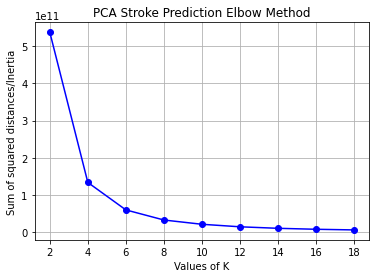

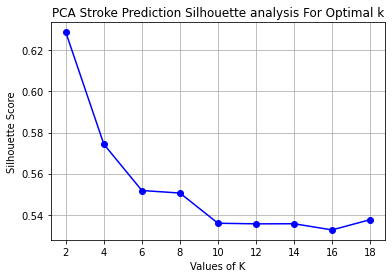

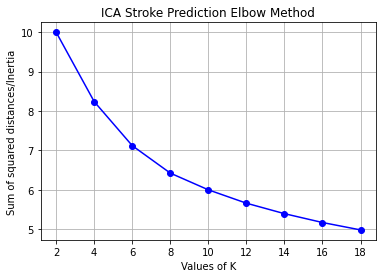

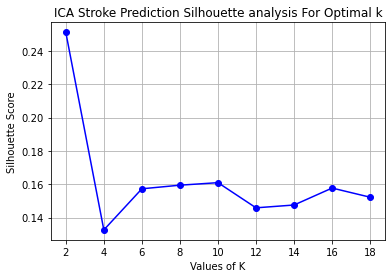

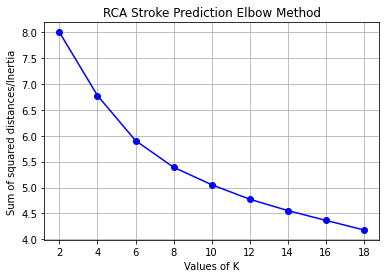

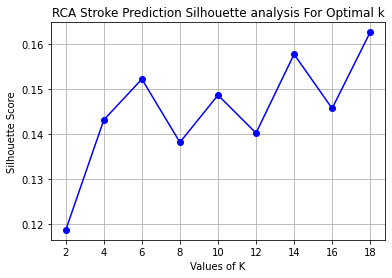

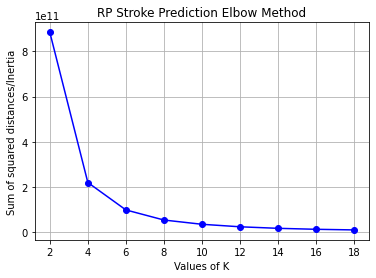

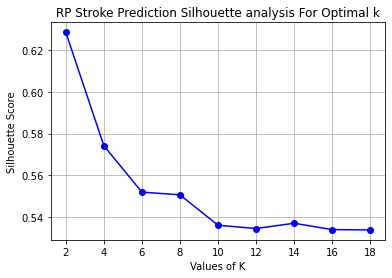

In [34]:
kmeans(pca_stroke, stroke_y, 20, 'PCA Stroke Prediction')
kmeans(ica_stroke, stroke_y, 20, 'ICA Stroke Prediction')
kmeans(rca_stroke, stroke_y, 20, 'RCA Stroke Prediction')
kmeans(rp_stroke, stroke_y, 20, 'RP Stroke Prediction')

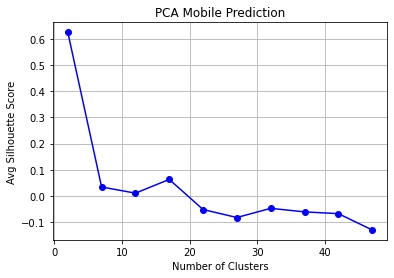

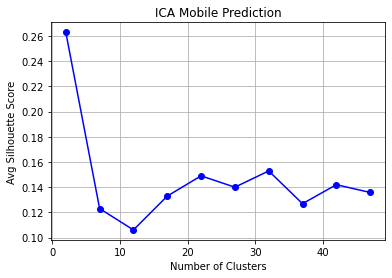

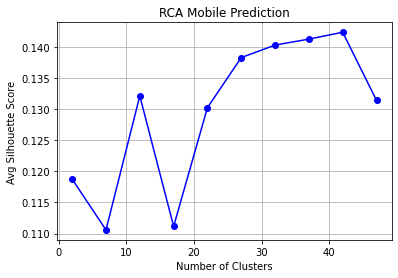

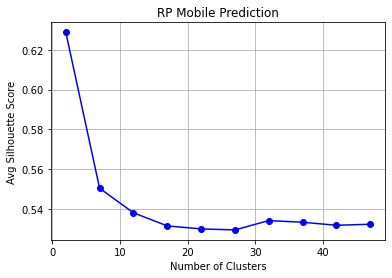

In [35]:
EM(pca_stroke, stroke_y, 'PCA Mobile Prediction')
EM(ica_stroke, stroke_y, 'ICA Mobile Prediction')
EM(rca_stroke, stroke_y, 'RCA Mobile Prediction')
EM(rp_stroke, stroke_y, 'RP Mobile Prediction')

#### Mobile Prediction

In [36]:
pca_mobile = PCA(n_components=2).fit_transform(mobile_X)
ica_mobile = ICA(n_components=21).fit_transform(mobile_X)
rca_mobile = ICA(n_components=8).fit_transform(mobile_X)
rp_mobile = run_RP(stroke_X, 11, hist=False)

C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:550: UserWarning: n_components is too large: it will be set to 20
  warnings.warn(
C:\Users\Derek Yong\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


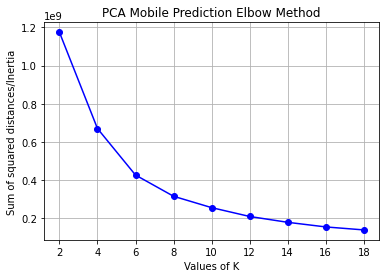

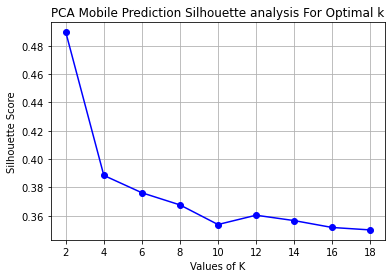

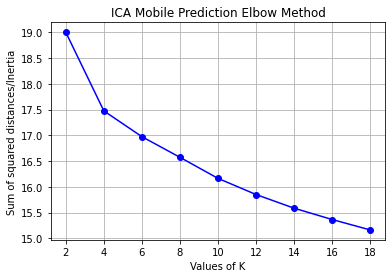

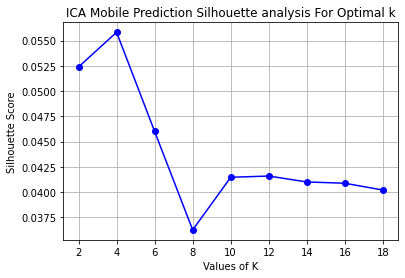

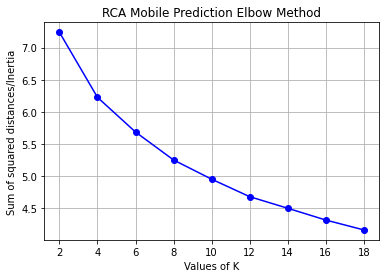

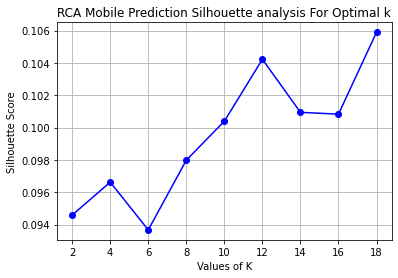

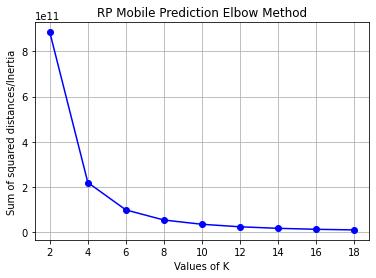

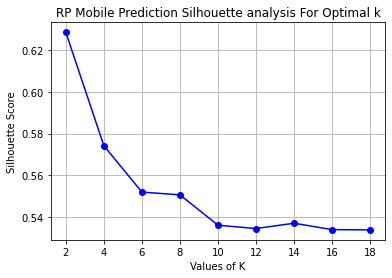

In [37]:
kmeans(pca_mobile, mobile_y, 20, 'PCA Mobile Prediction')
kmeans(ica_mobile, mobile_y, 20, 'ICA Mobile Prediction')
kmeans(rca_mobile, mobile_y, 20, 'RCA Mobile Prediction')
kmeans(rp_mobile, mobile_y, 20, 'RP Mobile Prediction')

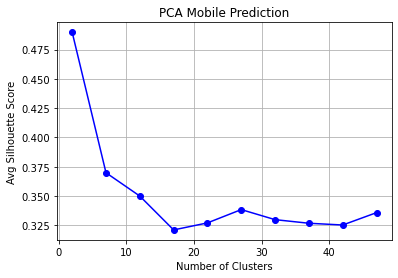

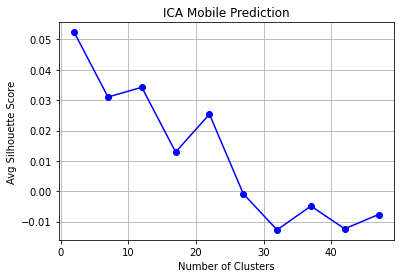

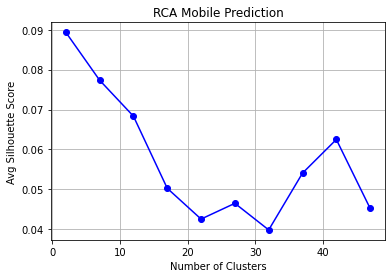

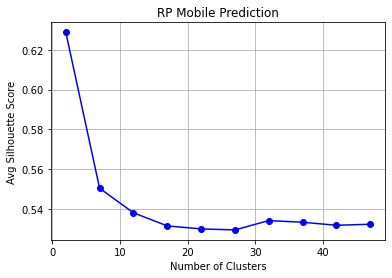

In [38]:
EM(pca_mobile, mobile_y, 'PCA Mobile Prediction')
EM(ica_mobile, mobile_y,'ICA Mobile Prediction')
EM(rca_mobile, mobile_y,'RCA Mobile Prediction')
EM(rp_mobile, mobile_y,'RP Mobile Prediction')

### Step 4: Dimensionality Reduction Algorithms on Neural Network

#### Mobile Prediction

In [83]:
X_train, X_test, y_train, y_test = train_test_split(np.array(mobile_X),np.array(mobile_y), test_size=0.30)
gd_NN = MLPClassifier(hidden_layer_sizes=(80,), activation='tanh', learning_rate_init=0.001, random_state=100)
gd_train_sizes, gd_train_scores, gd_test_scores, gd_fit_times, _ = learning_curve(
        gd_NN,
        mobile_X,
        mobile_y,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.01, 1.0, 50),
        return_times=True,
    )
gd_train_scores_mean = np.mean(gd_train_scores, axis=1)
gd_test_scores_mean = np.mean(gd_test_scores, axis=1)
gd_fit_times_mean = np.mean(gd_fit_times, axis=1)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(np.array(pca_mobile),np.array(mobile_y), test_size=0.30)
pca_NN = MLPClassifier(hidden_layer_sizes=(80,), activation='tanh', learning_rate_init=0.001, random_state=100)
pca_train_sizes, pca_train_scores, pca_test_scores, pca_fit_times, _ = learning_curve(
        pca_NN,
        pca_mobile,
        mobile_y,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.01, 1.0, 50),
        return_times=True,
    )
pca_train_scores_mean = np.mean(pca_train_scores, axis=1)

pca_test_scores_mean = np.mean(pca_test_scores, axis=1)

pca_fit_times_mean = np.mean(pca_fit_times, axis=1)


In [85]:
X_train, X_test, y_train, y_test = train_test_split(np.array(ica_mobile),np.array(mobile_y), test_size=0.30)
ica_NN = MLPClassifier(hidden_layer_sizes=(80,), activation='tanh', learning_rate_init=0.001, random_state=100)
ica_train_sizes, ica_train_scores, ica_test_scores, ica_fit_times, _ = learning_curve(
        ica_NN,
        ica_mobile,
        mobile_y,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.01, 1.0, 50),
        return_times=True,
    )
ica_train_scores_mean = np.mean(ica_train_scores, axis=1)

ica_test_scores_mean = np.mean(ica_test_scores, axis=1)

ica_fit_times_mean = np.mean(ica_fit_times, axis=1)


In [86]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rca_mobile),np.array(mobile_y), test_size=0.30)
rca_NN = MLPClassifier(hidden_layer_sizes=(80,), activation='tanh', learning_rate_init=0.001, random_state=100)
rca_train_sizes, rca_train_scores, rca_test_scores, rca_fit_times, _ = learning_curve(
        rca_NN,
        rca_mobile,
        mobile_y,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.01, 1.0, 50),
        return_times=True,
    )
rca_train_scores_mean = np.mean(rca_train_scores, axis=1)

rca_test_scores_mean = np.mean(rca_test_scores, axis=1)

rca_fit_times_mean = np.mean(rca_fit_times, axis=1)


In [75]:
# X_train, X_test, y_train, y_test = train_test_split(np.array(rp_mobile),np.array(mobile_y), test_size=0.30)
# rp_NN = MLPClassifier(hidden_layer_sizes=(80,), activation='tanh', learning_rate_init=0.001, random_state=100)
# rp_train_sizes, rp_train_scores, rp_test_scores, rp_fit_times, _ = learning_curve(
#         rp_NN,
#         rp_mobile,
#         mobile_y,
#         scoring='accuracy',
#         cv=5,
#         n_jobs=-1,
#         train_sizes=np.linspace(0.01, 1.0, 50),
#         return_times=True,
#     )
# rp_train_scores_mean = np.mean(rp_train_scores, axis=1)

# rp_test_scores_mean = np.mean(rp_test_scores, axis=1)

# rp_fit_times_mean = np.mean(rp_fit_times, axis=1)


ValueError: Found input variables with inconsistent numbers of samples: [4909, 2000]

NameError: name 'rp_fit' is not defined

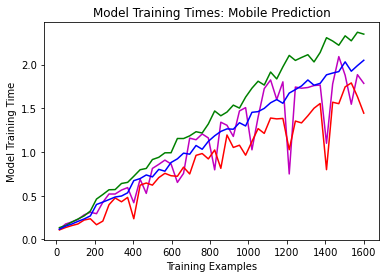

In [89]:
compare_fit_time(gd_train_sizes, gd_fit_times_mean, pca_fit_times_mean, ica_fit_times_mean, rca_fit_times_mean, 'Mobile Prediction')

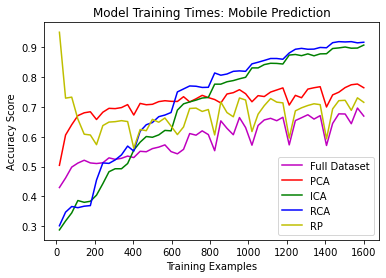

In [90]:
compare_plot_learning_curve('Mobile Prediction', gd_train_sizes, gd_test_scores_mean, pca_test_scores_mean, ica_test_scores_mean, rca_test_scores_mean)

### Step 5: Clustering on Neural Network